# Main testing

In [46]:
import gym
import minihack
import numpy as np
import math
import matplotlib.pyplot as plt
import IPython.display as display
from typing import Tuple, List
from utils import *
from algorithms import *
from logic import *

## Environment initialization

In [47]:
env = gym.make("MiniHack-River-Narrow-v0", observation_keys=("chars", "pixel"))
state = env.reset()
env.render()


Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                            ..................}                                 
                            ...............@..}                                 
                            ............. `...}                                 
                            .   `......   `...}                                 
                           

In [48]:
game_map = state['chars'].copy()
game_gui = state['pixel']

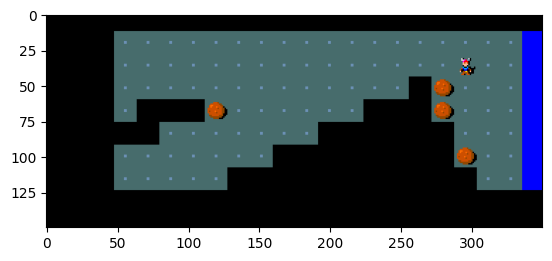

In [49]:
plt.imshow(game_gui[100:250, 400:750]) #Immagine ristretta con range [y][x]

## Variables that represent the change of state of the agent

### In a state automata style

In [50]:
BOULDER_REACHED = False
HAS_BOULDER = False
RIVER_REACHED = False
BOULDER_PUSHED = False

## Initial State of the agent

In [51]:
boulders = get_boulder_locations(game_map)
river = get_river_locations(game_map)
agent_initial_pos = get_player_location(game_map)
print(agent_initial_pos)

best_boulder = get_best_global_distance(agent_initial_pos, boulders, river)
print("Best boulder: ", best_boulder)

river_target,_ = get_min_distance_point_to_points(best_boulder[0], best_boulder[1], river)
print("River target: ", river_target)
best_to_river = a_star(game_map, best_boulder, river_target, True, get_optimal_distance_point_to_point)
print("Best to river: ", best_to_river)

_,first_push = position_for_boulder_push(best_boulder, best_to_river[1])
print("First push: ", first_push)

(8, 43)
Best boulder:  (9, 42)
River target:  (9, 46)
Best to river:  [(9, 42), (9, 43), (9, 44), (9, 45), (9, 46)]
First push:  (9, 41)


## Path Agent to Boulder

In [52]:
if game_map[first_push] == ord(" "): # the target is an unseen block
    agent_to_boulder = a_star(game_map, agent_initial_pos, best_boulder, False, get_optimal_distance_point_to_point)
    print("Agent to boulder considering boulder: ", agent_to_boulder)
    agent_to_boulder = agent_to_boulder[:-1] # remove the last step
else:
    agent_to_boulder = a_star(game_map, agent_initial_pos, first_push, False, get_optimal_distance_point_to_point)

print("Agent to boulder: ", agent_to_boulder)

Agent to boulder considering boulder:  [(8, 43), (9, 42)]
Agent to boulder:  [(8, 43)]


## Value needed to understand the changes in the state

In [53]:
actions, names = actions_from_path(agent_initial_pos, agent_to_boulder[1:])
print("Names: ", names)
print("Actions: ", actions)
actual_target = first_push
previous_pos = None
old_state = game_map

Names:  []
Actions:  []


In [54]:

while not BOULDER_REACHED:
    while len(actions) > 0:
        action = actions.pop(0)
        print("Path: ", agent_to_boulder)
        agent_to_boulder.pop(0)
        new_state, reward, _, _ = env.step(action) # remove the head of the list
        new_map = new_state['chars'].copy()
        agent_pos = get_player_location(new_map)  

        print("Agent position: ", agent_pos)
        print("Actual target: ", actual_target)

        if actual_target == agent_pos:
            BOULDER_REACHED = True
            break 

        #FIXME: add exit condition if the agent is in the neighbor of the target beacuse it can't reach the actual target

        if is_player_same_position(agent_pos, previous_pos):
            avoid_the_obstacle(new_map, agent_pos, action, env)
        else:
            if are_less_black_blocks(game_map, new_map):
                new_path, tmp_actual_target, best_boulder = push_new_boulder(game_map, new_map, agent_pos, river, best_boulder)
                if new_path is not None:
                    print("NEW PATH", new_path)
                    actions, names = actions_from_path(agent_pos, new_path[1:])
                    agent_to_boulder = new_path # update the path
                    actual_target = tmp_actual_target #update the actual target
                    previous_pos = agent_pos #update the old state position
                    old_state = new_map #update the old state map
                    print("TMP TARGET: ", actual_target)
                    continue
                else:
                    new_path = check_better_path(new_map, best_boulder, actual_target)
                    if len(new_path) < len(agent_to_boulder):
                        actions, _ = actions_from_path(agent_pos, new_path[1:])
                        agent_to_boulder = new_path

KeyboardInterrupt: 